# Epymorph dev log: May 16th, 2023

_author: Tyler Coles_

_as of git hash: 121f61faed35fa555324e95c7d6e83a1a93da098_

Keeping a bunch of named examples in the main project is getting confusing. Why don't we convert them to Jupyter notebooks?

In [11]:
# Here are some common elements used in all of the simulations.

import time
from datetime import date

import matplotlib.pyplot as plt
import numpy as np

from epymorph.geo import Geo
from epymorph.model.geo_pei import load_geo as load_pei_geo
from epymorph.model.ipm_pei import PeiModelBuilder
from epymorph.model.mvm_pei import load_mvm as load_pei_mvm
from epymorph.movement import load_movement_spec
from epymorph.simulation import Output, Simulation
from epymorph.util import stridesum

param = {
    'theta': 0.1,
    'move_control': 0.9,
    'infection_duration': 4.0,
    'immunity_duration': 90.0,
    'infection_seed_loc': 0,
    'infection_seed_size': 10_000
}
start_date = date(2023, 1, 1)
duration_days = 150

# Plot infections for all populations


def plot_inf(out: Output, geo: Geo) -> None:
    event = 0
    fig, ax = plt.subplots()
    ax.set_title('Infection incidence')
    ax.set_xlabel('days')
    ax.set_ylabel('infections (per 100k population)')
    x_axis = list(range(out.ctx.clock.num_days))
    for pop_idx in range(geo.nodes):
        values = stridesum(
            out.incidence[:, pop_idx, event], out.ctx.clock.num_steps)
        # Scaled by population:
        y_axis = values * 100_000 / geo.data['population'][pop_idx]
        ax.plot(x_axis, y_axis, label=geo.labels[pop_idx])
    ax.legend()
    fig.tight_layout()
    plt.show()

# Plot prevalence for the first population


def plot_prev(out: Output) -> None:
    pop = 0
    fig, ax = plt.subplots()
    ax.set_title('Prevalence in FL')
    ax.set_xlabel('days')
    ax.set_ylabel('persons (log scale)')
    ax.set_yscale('log')
    x_axis = [t.tausum for t in out.ctx.clock.ticks]
    events = ['S', 'I', 'R']
    for i, event in enumerate(events):
        y_axis = out.prevalence[:, pop, i]
        ax.plot(x_axis, y_axis, label=event)
    ax.legend()
    fig.tight_layout()
    plt.show()


## pei_py

This was our first working example: executing a Pei-like simulation using hard-coded models.

Simulation time: 0.498s


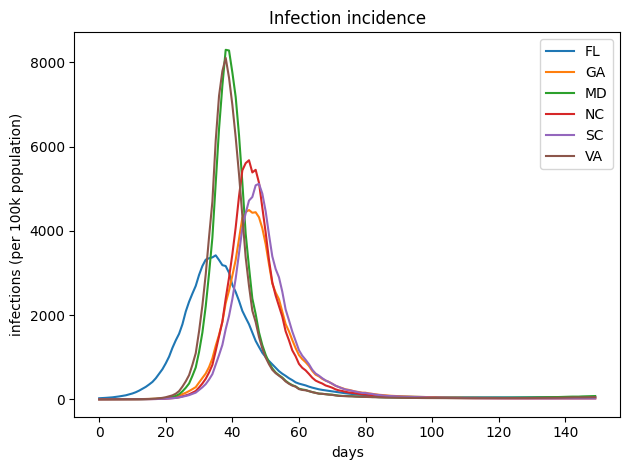

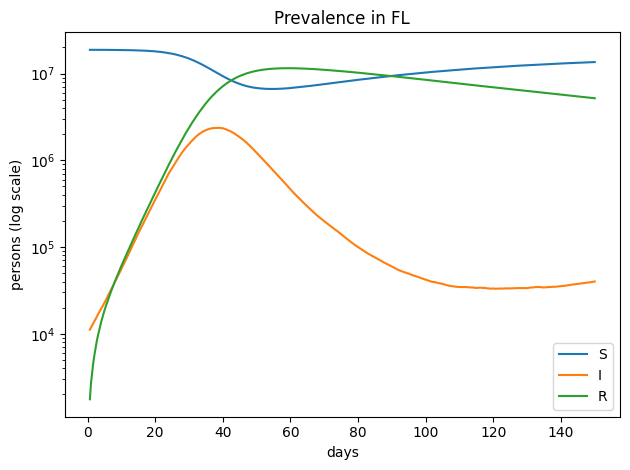

In [12]:
# Set up the simulation...
geo = load_pei_geo()
sim = Simulation(
    geo=geo,
    ipm_builder=PeiModelBuilder(),
    mvm_builder=load_pei_mvm()
)

# ... and run it.
t0 = time.perf_counter()
out = sim.run(
    param=param,
    start_date=start_date,
    duration_days=duration_days,
    rng=np.random.default_rng(1)
)
t1 = time.perf_counter()
print(f"Simulation time: {(t1 - t0):.3f}s")

plot_inf(out, geo)
plot_prev(out)


## pei_spec

This next example attempts to accomplish the same as the above except by parsing the movement model from our custom spec file.

Simulation time: 0.477s


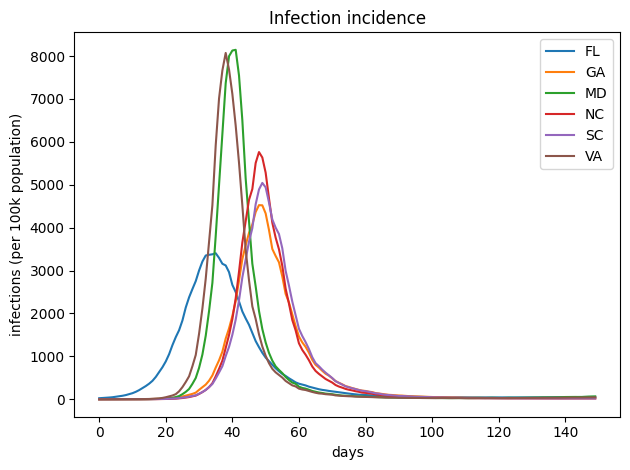

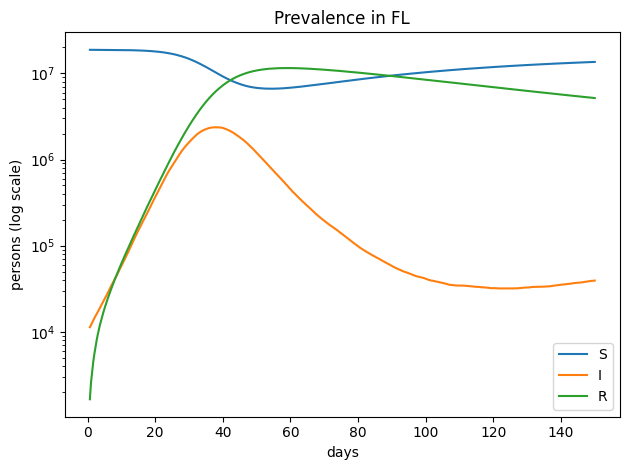

In [13]:
movement_file = './data/pei.movement'

# Load movement model from spec file
with open(movement_file, 'r') as file:
    spec_string = file.read()
    mvm_builder = load_movement_spec(spec_string)

# Set up the simulation...
geo = load_pei_geo()
sim = Simulation(
    geo=geo,
    ipm_builder=PeiModelBuilder(),
    mvm_builder=mvm_builder
)

# ... and run it.
t0 = time.perf_counter()
out = sim.run(
    param=param,
    start_date=start_date,
    duration_days=duration_days,
    rng=np.random.default_rng(1)
)
t1 = time.perf_counter()
print(f"Simulation time: {(t1 - t0):.3f}s")

plot_inf(out, geo)
plot_prev(out)


## pei_spec_n

This next example was an attempt to do something a bit more interesting with the output handling. By running the simulation (using the same settings as above) for 10 iterations, we can build up a ribbon of possible values at each time step. This is a common graphing approach for stochastic simulations.

Total simulation time: 4.534s
Mean simulation time: 0.453s


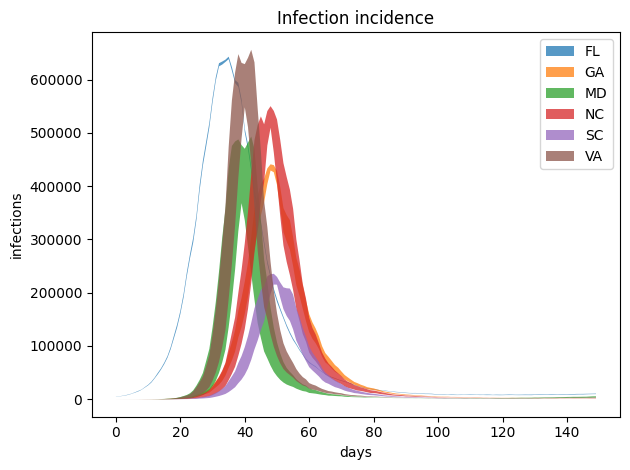

In [14]:
trials = 10
movement_file = './data/pei.movement'

# Load movement model from spec file
with open(movement_file, 'r') as file:
    spec_string = file.read()
    mvm_builder = load_movement_spec(spec_string)

# Set up the simulation...
geo = load_pei_geo()
sim = Simulation(
    geo=geo,
    ipm_builder=PeiModelBuilder(),
    mvm_builder=mvm_builder
)

# ... and run it.
t0 = time.perf_counter()
out = sim.run_trials(
    trials,
    param=param,
    start_date=start_date,
    duration_days=duration_days,
    rng=np.random.default_rng(1)
)
t1 = time.perf_counter()
print(f"Total simulation time: {(t1 - t0):.3f}s")
print(f"Mean simulation time: {((t1 - t0) / trials):.3f}s")

# Plot infections for all populations:
event = 0
steps = out.ctx.clock.num_steps
fig, ax = plt.subplots()
ax.set_title('Infection incidence')
ax.set_xlabel('days')
ax.set_ylabel('infections')
x_axis = list(range(out.ctx.clock.num_days))
for pop_idx in range(geo.nodes):
    mins = stridesum(out.min_incidence[:, pop_idx, event], steps)
    maxs = stridesum(out.max_incidence[:, pop_idx, event], steps)
    ax.fill_between(x_axis, y1=mins, y2=maxs,  # type: ignore
                    alpha=0.75, label=geo.labels[pop_idx])
ax.legend()
fig.tight_layout()
plt.show()
